# A. Data Wrangling

# 1. Purpose of This Data Science Project

The purpose of this data science project is to develop a pricing model for rents listed on rental postings. Property owners would benefit from listing their property at an appropriate price and in line with their position in the market. Owners would also benefit from insights to high-value versus low-value features.

# 2. Import Packages

In [298]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.options.display.max_columns = None


# 3. Objectives of This Notebook

- To determine if the data we have could be use to develop a pricing model
    - Verify that there is an appropriate target feature
    - Verify that there are potentially useful features
- Verify that there are not fundamental issues with the data

# 4. Loading Data

In [257]:
immo_data= pd.read_csv('../data/raw/immo_data.csv')

In [258]:
rentals = immo_data.copy()

In [259]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

In [260]:
rentals.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.0,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.0,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.9,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


- We observe that the dataframe has 49 features associated with 268,850 apartment records that have been put up for rent. 
- We note that there are various price-related features that will be examined to determine the appropriate target feature. For instance, we need to choose between totalRent and baseRent. Furthermore, we neet to determin the relationships between such features as heatingCosts and the possible target features of totalRent and baseRent.
- The dataframe features comprise of 4 main datatypes, including 6 boolean, 18 float, 6 integer and 19 object datatypes. We would need to verfiy that these datatypes are accurate in the context of our goal of developing a price model for rent. We also note a varying level of quality associated with each feature in terms of how many records exist for the particular feature. We would need to deal with those features that have a lot of empty values. 
- Finally, we observe that the amount of memory used up by the dataframe is ~89, which is manageable. Higher capacity data-processing cloud computing technologies may not be necessary.

## 5. Reviewing the Data 

## Reviewing Missing Values for the remaining features 

In [261]:
#To determine counts and percentage of valid entries
missing = pd.concat([rentals.isnull().sum(), rentals.isnull().mean() * 100], axis = 1)
missing.columns = ['Count', '%age total']
missing.sort_values(by = 'Count', ascending = False)

,Count,%age total
telekomHybridUploadSpeed,223830,83.254603
electricityKwhPrice,222004,82.575414
electricityBasePrice,222004,82.575414
energyEfficiencyClass,191063,71.066766
lastRefurbish,188139,69.979171
heatingCosts,183332,68.191185
noParkSpaces,175798,65.388879
petsAllowed,114573,42.615957
interiorQual,112665,41.906267
thermalChar,106506,39.615399


We notice that there are many features with missing values. We will go ahead and delete those features that have over 15% of their values missing

In [262]:
rentals = rentals.loc[:,~(missing['%age total'] > 15)]

In [263]:
rentals.shape

(268850, 28)

## Reviewing objects

In [264]:
rentalsObj =rentals.select_dtypes('object')

In [265]:
rentalsObj.head()

,regio1,telekomTvOffer,geo_bln,geo_krs,street,typeOfFlat,regio2,regio3,description,date
0,Nordrhein_Westfalen,ONE_YEAR_FREE,Nordrhein_Westfalen,Dortmund,Sch&uuml;ruferstra&szlig;e,ground_floor,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,May19
1,Rheinland_Pfalz,ONE_YEAR_FREE,Rheinland_Pfalz,Rhein_Pfalz_Kreis,no_information,ground_floor,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,May19
2,Sachsen,ONE_YEAR_FREE,Sachsen,Dresden,Turnerweg,apartment,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,Oct19
3,Sachsen,ONE_YEAR_FREE,Sachsen,Mittelsachsen_Kreis,Gl&uuml;ck-Auf-Stra&szlig;e,other,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,May19
4,Bremen,NaN,Bremen,Bremen,Hermann-Henrich-Meier-Allee,apartment,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Feb20


In [266]:
rentalsObj.nunique()

regio1                16
telekomTvOffer         3
geo_bln               16
geo_krs              419
street             52373
typeOfFlat            10
regio2               419
regio3              8684
description       212621
date                   4
dtype: int64

In [267]:
#regio1 refers to the state in Germany. There are 16.

rentalsObj['regio1'].value_counts() 

Nordrhein_Westfalen       62863
Sachsen                   58154
Bayern                    21609
Sachsen_Anhalt            20124
Hessen                    17845
Niedersachsen             16593
Baden_Württemberg         16091
Berlin                    10406
Thüringen                  8388
Rheinland_Pfalz            8368
Brandenburg                6954
Schleswig_Holstein         6668
Mecklenburg_Vorpommern     6634
Hamburg                    3759
Bremen                     2965
Saarland                   1429
Name: regio1, dtype: int64

In [268]:
#telekomTvOffer refers to the option of cable service being included with the rent.There are 3 categories. 
rentalsObj['telekomTvOffer'].value_counts() 

ONE_YEAR_FREE    227632
NONE               4957
ON_DEMAND          3642
Name: telekomTvOffer, dtype: int64

The data owner noted that geo_bln and regio1 have the same values,as well as geo_krs and regio2.
We also observe this from their value counts that are identical. We will confirm this and eliminate redundant features.


In [269]:
#There are no values that are different between regio1 and geo_bln. 
#We will drop geo_bln
(rentalsObj["regio1"] != rentalsObj['geo_bln']).sum() 

0

In [270]:
#There are no values that are different between regio2 and geo_krs. 
#We will drop geo_krs
(rentalsObj["regio2"] != rentalsObj["geo_krs"]).sum()

0

In [271]:
#typeOfFlat gives information on the kind of apartment it is. It has 10 categories.
rentalsObj['typeOfFlat'].value_counts()

apartment              131522
roof_storey             34787
ground_floor            31538
other                    9519
maisonette               9319
raised_ground_floor      5628
penthouse                3568
terraced_flat            3385
half_basement            2013
loft                      957
Name: typeOfFlat, dtype: int64

In [272]:
#regio3 refers to the city or town of the apartment
#There are over 8600 towns in the dataframe suggesting a high amount of cardinality.

rentalsObj['regio3'].value_counts()

Innenstadt                                                4751
Stadtmitte                                                2697
Altstadt                                                  2334
Sonnenberg                                                1913
Kaßberg                                                   1712
Mitte                                                     1611
Hilbersdorf                                               1297
Schloßchemnitz                                            1266
Zentrum                                                   1135
Südstadt                                                  1117
Gablenz                                                    885
Merseburg                                                  884
Freiberg                                                   875
Bernsdorf                                                  851
Stadtfeld_Ost                                              827
Mitte_Mitte                                            

In [273]:
#description provides a summary of property details in german. Text analytics is out of scope for this project. 
#We will drop this column
rentalsObj['description'].head()

0    Die ebenerdig zu erreichende Erdgeschosswohnun...
1    Alles neu macht der Mai – so kann es auch für ...
2    Der Neubau entsteht im Herzen der Dresdner Neu...
3    Abseits von Lärm und Abgasen in Ihre neue Wohn...
4    Es handelt sich hier um ein saniertes Mehrfami...
Name: description, dtype: object

In [274]:
#date provides information on when (four dates) the posting was scraped from the web. 
#The date does not add value to the analysis. We will drop the column
rentalsObj['date'].value_counts()

Feb20    79276
May19    76047
Oct19    66685
Sep18    46842
Name: date, dtype: int64

In [275]:
#Droping columns
rentals.drop(columns = ['geo_bln','geo_krs','street','description', 'date'], inplace = True)

In [276]:
rentals.shape[1]

23

## Reviewing Numeric Features 

In [277]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

rentalsNum= rentals.select_dtypes(include=numerics)

In [278]:
rentalsNum.head()

,serviceCharge,picturecount,pricetrend,telekomUploadSpeed,scoutId,baseRent,livingSpace,baseRentRange,geo_plz,noRooms,noRoomsRange,livingSpaceRange
0,245.00,6,4.62,10.0,96107057,595.0,86.00,4,44269,4.0,4,4
1,134.00,8,3.47,10.0,111378734,800.0,89.00,5,67459,3.0,3,4
2,255.00,8,2.72,2.4,113147523,965.0,83.80,6,1097,3.0,3,4
3,58.15,9,1.53,40.0,108890903,343.0,58.15,2,9599,3.0,3,2
4,138.00,19,2.46,NaN,114751222,765.0,84.97,5,28213,3.0,3,4


In [279]:
rentalsNum.describe().T

,count,mean,std,min,25%,50%,75%,max
serviceCharge,261941.0,1.512061e+02,3.082958e+02,0.00,95.0,1.350000e+02,1.900000e+02,1.461180e+05
picturecount,268850.0,9.791958e+00,6.408399e+00,0.00,6.0,9.000000e+00,1.300000e+01,1.210000e+02
pricetrend,267018.0,3.389001e+00,1.964874e+00,-12.33,2.0,3.390000e+00,4.570000e+00,1.492000e+01
telekomUploadSpeed,235492.0,2.880493e+01,1.633715e+01,1.00,10.0,4.000000e+01,4.000000e+01,1.000000e+02
scoutId,268850.0,1.069697e+08,1.250093e+07,28871743.00,106691034.0,1.111584e+08,1.137688e+08,1.157117e+08
baseRent,268850.0,6.941294e+02,1.953602e+04,0.00,338.0,4.900000e+02,7.990000e+02,9.999999e+06
livingSpace,268850.0,7.435555e+01,2.547592e+02,0.00,54.0,6.732000e+01,8.700000e+01,1.111110e+05
baseRentRange,268850.0,3.765256e+00,2.214357e+00,1.00,2.0,3.000000e+00,5.000000e+00,9.000000e+00
geo_plz,268850.0,3.728302e+04,2.779804e+04,852.00,9128.0,3.866700e+04,5.707200e+04,9.999800e+04
noRooms,268850.0,2.641261e+00,2.633440e+00,1.00,2.0,3.000000e+00,3.000000e+00,9.999900e+02


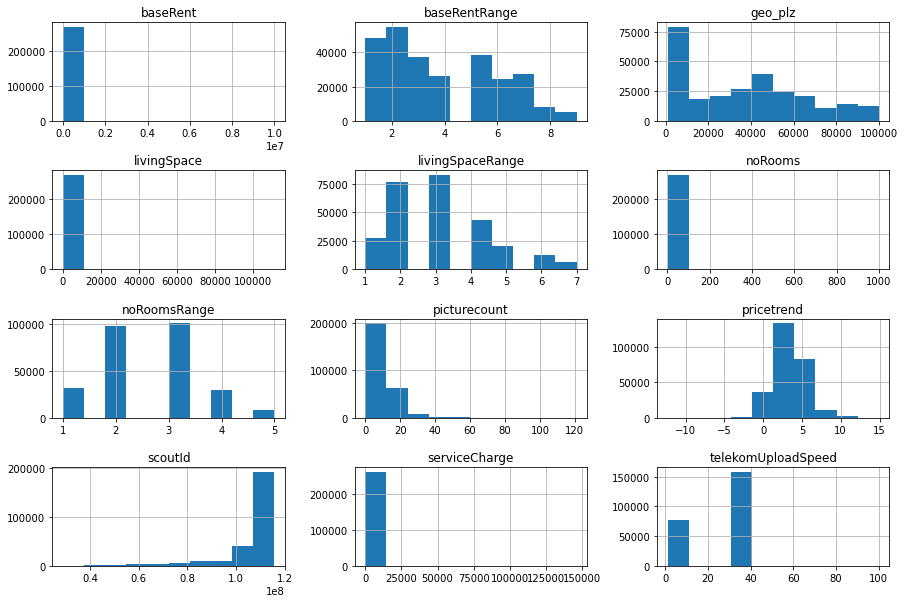

In [280]:
rentalsNum.hist(figsize = (15, 10))
plt.subplots_adjust(hspace= 0.5)


We note the following information from the data owner:
- scoutId is an identifier for each rental listing. It has no relevance for analysis. This will be dropped.
- pricetrend is metric determined by the data owner. There is no visibility to what this means. This will be dropped.
- geo_plz should be an object because it is the zip code of each property
- noRoomsRange is the histogram bin number corresponding to the noRooms. This is additional information we do not need. This will be dropped.
- livngSpaceRange is the historgram bin number corresponding to livingSpace. This is additional information we do not need. This will be dropped.
- baseRentRange is the historgram bin number corresponding to baseRent. This is additional information we do not need. This will be dropped.

In [281]:
rentalsNum.drop(columns = ['pricetrend','geo_plz','scoutId','noRoomsRange', 'livingSpaceRange', 'baseRentRange'], inplace = True)

C:\Users\zebin\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


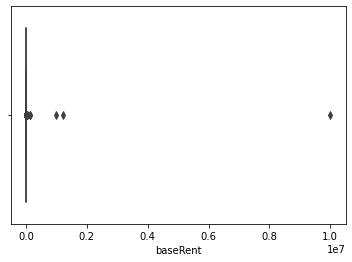

In [282]:
_= sns.boxplot(x = 'baseRent', data = rentalsNum)
#We observe high monthly rent rates, going to 10bln euros. For now, we will restrict max rent to 50,000 euros
# and min rent to 50 euros

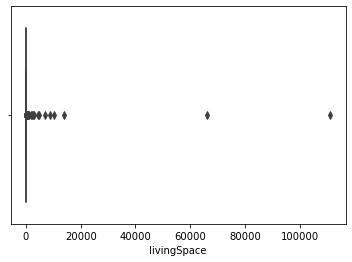

In [283]:
_= sns.boxplot(x = 'livingSpace', data = rentalsNum)  
#We observe units with large sizes. We will restrict the max unit area to 1000 sqm and min area to 10 sqm (parking lot). 

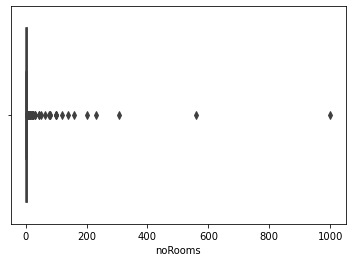

In [284]:
_= sns.boxplot(x = 'noRooms', data = rentalsNum)
#We observe units with many rooms. For now, we will restrict max number of rooms to 100 and min number of rooms to 1. 

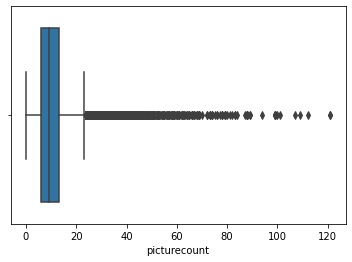

In [285]:
_= sns.boxplot(x = 'picturecount', data = rentalsNum)
#We will restrict number of pictures to 50

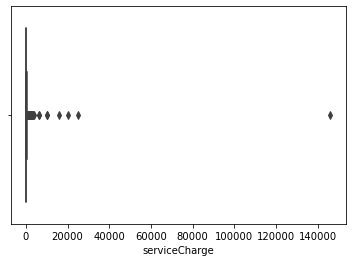

In [286]:
_= sns.boxplot(x = 'serviceCharge', data = rentalsNum)
#For now,we will restrict max serviceCharge to 10,000 euros

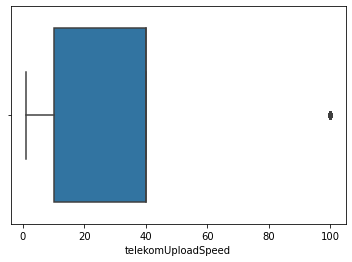

In [287]:
_= sns.boxplot(x = 'telekomUploadSpeed', data = rentalsNum)

In [288]:
#Adding the restrictions 
rent = (rentalsNum.baseRent > 50) & (rentalsNum.baseRent < 4000)
space = (rentalsNum.livingSpace > 10) & (rentalsNum.livingSpace < 300)
rooms = (rentalsNum.noRooms > 1) & (rentalsNum.noRooms < 10)
pictures = (rentalsNum.picturecount < 50)
charge = (rentalsNum.serviceCharge < 1000)
selectRows = rent & space & rooms & pictures & charge

In [289]:
#Including only select rows in our numeric dataframe
rentalsNum = rentalsNum[selectRows]

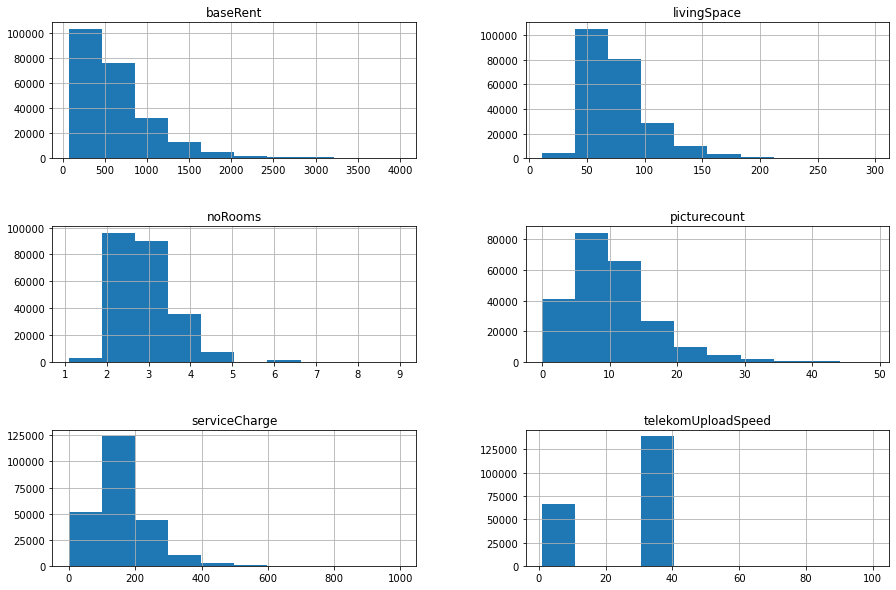

In [290]:
rentalsNum.hist(figsize = (15, 10))
plt.subplots_adjust(hspace= 0.5)

In [291]:
#Including only select rows in our main dataframe
rentals = rentals[selectRows]

In [292]:
#Dropping aforementioned columns
rentals.drop(columns = ['pricetrend','scoutId','noRoomsRange','livingSpaceRange', 'baseRentRange'], inplace = True)

In [293]:
#Converting geo_plz to string
rentals['geo_plz'] = rentals['geo_plz'].astype(str)

In [294]:
rentals.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 234171 entries, 0 to 268849
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   regio1              234171 non-null  object 
 1   serviceCharge       234171 non-null  float64
 2   telekomTvOffer      206247 non-null  object 
 3   newlyConst          234171 non-null  bool   
 4   balcony             234171 non-null  bool   
 5   picturecount        234171 non-null  int64  
 6   telekomUploadSpeed  205591 non-null  float64
 7   hasKitchen          234171 non-null  bool   
 8   cellar              234171 non-null  bool   
 9   baseRent            234171 non-null  float64
 10  livingSpace         234171 non-null  float64
 11  lift                234171 non-null  bool   
 12  typeOfFlat          203935 non-null  object 
 13  geo_plz             234171 non-null  object 
 14  noRooms             234171 non-null  float64
 15  garden              234171 non-nul

In [295]:
rentals.head()

,regio1,serviceCharge,telekomTvOffer,newlyConst,balcony,picturecount,telekomUploadSpeed,hasKitchen,cellar,baseRent,livingSpace,lift,typeOfFlat,geo_plz,noRooms,garden,regio2,regio3
0,Nordrhein_Westfalen,245.00,ONE_YEAR_FREE,False,False,6,10.0,False,True,595.0,86.00,False,ground_floor,44269,4.0,True,Dortmund,Schüren
1,Rheinland_Pfalz,134.00,ONE_YEAR_FREE,False,True,8,10.0,False,False,800.0,89.00,False,ground_floor,67459,3.0,False,Rhein_Pfalz_Kreis,Böhl_Iggelheim
2,Sachsen,255.00,ONE_YEAR_FREE,True,True,8,2.4,False,True,965.0,83.80,True,apartment,1097,3.0,False,Dresden,Äußere_Neustadt_Antonstadt
3,Sachsen,58.15,ONE_YEAR_FREE,False,True,9,40.0,False,False,343.0,58.15,False,other,9599,3.0,False,Mittelsachsen_Kreis,Freiberg
4,Bremen,138.00,NaN,False,True,19,NaN,False,False,765.0,84.97,False,apartment,28213,3.0,False,Bremen,Neu_Schwachhausen


In [299]:
datapath = 'C:\\Users\\zebin\\OneDrive\\Documents\\Education\\Data Science\\Springboard - Data Science\\Capstones\\Capstone_2\\german_apartment_rentals\\data\\processed'
# renaming the output data directory and re-running this notebook, for example,
# will recreate this (empty) directory and resave the data files.
# NB this is not a substitute for a modern data pipeline, for which there are
# various tools. However, for our purposes here, and often in a "one off" analysis,
# this is useful because we have to deliberately move/delete our data in order
# to overwrite it.
if not os.path.exists(datapath):
    os.mkdir(datapath)

In [300]:
datapath_rentals = os.path.join(datapath, 'rentals_cleaned.csv')
if not os.path.exists(datapath_rentals):
    rentals.to_csv(datapath_rentals, index=False)

In [296]:
%pwd

'C:\\Users\\zebin\\OneDrive\\Documents\\Education\\Data Science\\Springboard - Data Science\\Capstones\\Capstone_2\\german_apartment_rentals\\notebooks'